In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets

In [8]:
##########################
### SETTINGS
##########################

# Device

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

"""Targets are 40-dim vectors representing
    00 - 5_o_Clock_Shadow
    01 - Arched_Eyebrows
    02 - Attractive
    03 - Bags_Under_Eyes
    04 - Bald
    05 - Bangs
    06 - Big_Lips
    07 - Big_Nose
    08 - Black_Hair
    09 - Blond_Hair
    10 - Blurry
    11 - Brown_Hair
    12 - Bushy_Eyebrows
    13 - Chubby
    14 - Double_Chin
    15 - Eyeglasses
    16 - Goatee
    17 - Gray_Hair
    18 - Heavy_Makeup
    19 - High_Cheekbones
    20 - Male
    21 - Mouth_Slightly_Open
    22 - Mustache
    23 - Narrow_Eyes
    24 - No_Beard
    25 - Oval_Face
    26 - Pale_Skin
    27 - Pointy_Nose
    28 - Receding_Hairline
    29 - Rosy_Cheeks
    30 - Sideburns
    31 - Smiling
    32 - Straight_Hair
    33 - Wavy_Hair
    34 - Wearing_Earrings
    35 - Wearing_Hat
    36 - Wearing_Lipstick
    37 - Wearing_Necklace
    38 - Wearing_Necktie
    39 - Young
    """

# Hyperparameters
RANDOM_SEED = 123
BATCH_SIZE = 5000
FEATURE_IDX=31

Device: cpu


In [9]:
def get_dataloaders_celeba(batch_size, num_workers=0,
                           train_transforms=None,
                           test_transforms=None,
                           download=True):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.CelebA(root='data',
                                    split='train',
                                    transform=train_transforms,
                                    download=download)

    valid_dataset = datasets.CelebA(root='data',
                                    split='valid',
                                    transform=test_transforms)

    test_dataset = datasets.CelebA(root='data',
                                   split='test',
                                   transform=test_transforms)


    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)

    valid_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    return train_loader, valid_loader, test_loader

In [19]:
# Dataset
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor()
])


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=b264e31f-45e2-4b8d-9ef5-3a7a9c623811
To: C:\Users\cclab1\desktop\Eureka\Eureka1\data\celeba\img_align_celeba.zip
100%|█████████████████████████████████████████████████████████████████████████████| 1.44G/1.44G [00:53<00:00, 26.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: C:\Users\cclab1\desktop\Eureka\Eureka1\data\celeba\list_attr_celeba.txt
100%|█████████████████████████████████████████████████████████████████████████████| 26.7M/26.7M [00:01<00:00, 15.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: C:\Users\cclab1\desktop\Eureka\Eureka1\data\celeba\identity_CelebA.txt
100%|█████████████████████████████████████████████████████████████████████████████| 3.42M/3.42M [00:00<00:00, 6.40MB/s]
Downl

In [20]:
print("Training Set:\n")
for images,labels in train_loader:
    print("images dimension: ", images.size())
    print("labels dimension: ", labels.size())
    break

EXAMPLE_IMG=images[1]

print("\nValidation Set:\n")
for images,labels in valid_loader:
    print("images dimension: ", images.size())
    print("labels dimension: ", labels.size())
    break

print("\nTest Set:\n")
for images,labels in test_loader:
    print("images dimension: ", images.size())
    print("labels dimension: ", labels.size())
    break

Training Set:

images dimension:  torch.Size([5000, 3, 128, 128])
labels dimension:  torch.Size([5000, 40])

Validation Set:

images dimension:  torch.Size([5000, 3, 128, 128])
labels dimension:  torch.Size([5000, 40])

Test Set:

images dimension:  torch.Size([5000, 3, 128, 128])
labels dimension:  torch.Size([5000, 40])


In [29]:
class Reshape(nn.Module):
    def __init__(self,*args):
        super().__init__()
        self.shape = args

    def forward(self,x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self,x):
        return x[:,:,:128,:128]

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder=nn.Sequential(
            nn.Conv2d(3,32,stride=2,kernel_size=3,bias=False,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.Conv2d(32,64,stride=2,kernel_size=3,bias=False,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.Conv2d(64,64,stride=2,kernel_size=3,bias=False,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.Conv2d(64,64,stride=2,kernel_size=3,bias=False,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.Flatten()
        )

        self.z_mean=torch.nn.Linear(4096,200)
        self.z_log_var=torch.nn.Linear(4096,200)

        self.decoder=nn.Sequential(
            torch.nn.Linear(200,4096),
            Reshape(-1, 64, 8, 8),
            #
            nn.ConvTranspose2d(64,64,stride=2,kernel_size=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.ConvTranspose2d(64,64,stride=2,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.ConvTranspose2d(64,32,stride=2,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.ConvTranspose2d(32,3,stride=2,kernel_size=3,padding=1),
            #
            Trim(),
            nn.Sigmoid()
        )


    def reparameterize(self,z_mu,z_log_var):
        eps=torch.randn(z_mu.size(0),z_mu.size(1))
        z = z_mu + eps*torch.exp(z_log_var/2.)
        return z

    def encoding_fn(self,x):
        x=self.encoder(x)
        z_mean,z_log_var=self.z_mean(x),self.z_log_var(x)
        encoded=self.reparameterize(z_mean,z_log_var)
        return encoded

    def forward(self,x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded=self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [30]:
torch.manual_seed(RANDOM_SEED)
model=VAE()
model.to(DEVICE)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1, inplace=True)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
    (11): Dropout2d(p=0.25, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [31]:
def compute_avg_face(feature_idx, image_dim, dataloader, device=None, encoding_fn=None):
    avg_img_with_feat=torch.zeros(image_dim, dtype=torch.float32)
    avg_img_with_out_feat=torch.zeros(image_dim, dtype=torch.float32)

    num_img_with_feat=0
    num_img_with_out_feat=0

    for images, labels in dataloader:
        idx_img_with_feat=labels[:,feature_idx].to(torch.bool)

        if encoding_fn is None:
            embeddings=images
        else:
            with torch.no_grad():
                if device is not None:
                    images=images.to(device)
                embeddings=encoding_fn(images).to('cpu')


        avg_img_with_feat+=torch.sum(embeddings[idx_img_with_feat],axis=0)
        avg_img_with_feat+=torch.sum(embeddings[~idx_img_with_feat],axis=0)
        num_img_with_feat+=idx_img_with_feat.sum(axis=0)
        num_img_with_out_feat+=(~idx_img_with_feat).sum(axis=0)

    avg_img_with_feat/=num_img_with_feat
    avg_img_with_out_feat/=num_img_with_out_feat

    return avg_img_with_feat, avg_img_with_out_feat

In [32]:
avg_img_with_feat, avg_img_with_out_feat=compute_avg_face(feature_idx=FEATURE_IDX,
                                                          image_dim=200,
                                                          dataloader=train_loader,
                                                          device=DEVICE,
                                                          encoding_fn=model.encoding_fn)

In [33]:
diff= avg_img_with_feat - avg_img_with_out_feat

example_img=EXAMPLE_IMG.unsqueeze(0).to(DEVICE)

with torch.no_grad():
    encoded= model.encoding_fn(example_img).squeeze(0).to('cpu')

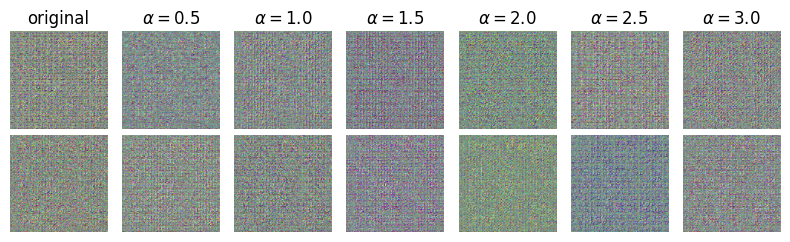

In [34]:
def plot_modified_faces(original, diff,
                        diff_coefficients=(0., 0.5, 1., 1.5, 2., 2.5, 3.),
                        decoding_fn=None,
                        device=None,
                        figsize=(8, 2.5)):

    fig, axes = plt.subplots(nrows=2, ncols=len(diff_coefficients),
                             sharex=True, sharey=True, figsize=figsize)


    for i, alpha in enumerate(diff_coefficients):
        more = original + alpha*diff
        less = original - alpha*diff


        if decoding_fn is not None:
            ######################################
            ### Latent -> Original space
            with torch.no_grad():

                if device is not None:
                    more = more.to(device).unsqueeze(0)
                    less = less.to(device).unsqueeze(0)

                more = decoding_fn(more).to('cpu').squeeze(0)
                less = decoding_fn(less).to('cpu').squeeze(0)
            ######################################

        if not alpha:
            s = 'original'
        else:
            s = f'$\\alpha=${alpha}'

        axes[0][i].set_title(s)
        axes[0][i].imshow(more.permute(1, 2, 0))
        axes[1][i].imshow(less.permute(1, 2, 0))
        axes[1][i].axison = False
        axes[0][i].axison = False


plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)



plt.tight_layout()
plt.show()